## Coursera Capstone Project Week 3 

### Question 1
Create a dataframe of Toronto Postal Code, Borough, and Neighborhood by scraping wikipedia

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [3]:
#scrape from wiki with pandas and BeatifulSoup
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))
df = df[0]
df=df.rename(columns = {'Postcode':'PostalCode', 'Neighbourhood': 'Neighborhood'})
df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [4]:
#Drop row when Borough = 'Not assigned', reset index
df = df[df.Borough != 'Not assigned'].reset_index(drop=True)
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


In [5]:
#replace neighborhood with borough when neighborhood = 'Not assigned'
df['Neighborhood'] = df['Neighborhood'].replace(to_replace='Not assigned', value = df.Borough)
df.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor
5,M7A,Queen's Park,Queen's Park
6,M9A,Downtown Toronto,Queen's Park
7,M1B,Scarborough,Rouge
8,M1B,Scarborough,Malvern
9,M3B,North York,Don Mills North


In [6]:
#groupby PostalCode and Borough then join neighborhood with the same
df = df.groupby(['PostalCode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [7]:
#Number of rows and columns in dataframe
df.shape

(103, 3)

### Question 2
Add Latitude and Longitude to dataframe

In [9]:
#read latitude and longitude from csv into df
latlong_df = pd.read_csv('https://cocl.us/Geospatial_data')
latlong_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
#rename Postal Code in order to facilitate join
latlong_df=latlong_df.rename(columns = {'Postal Code':'PostalCode'})


In [11]:
#left join latitude and longitude onto original dataframe
df_ll = pd.merge(df, latlong_df, on= 'PostalCode', how = "left")
df_ll.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


### Question 3
Explore and cluster the neighborhoods


In [12]:
#import the remaining libraries

import numpy as np # library to handle data in a vectorized manner

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-4.0.0               |             py_0         606 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be 

To save time, the latitude and longitude of Toronto are 43.651070 and -79.347015.

In [13]:

latitude = 43.651070
longitude = -79.347015

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_ll['Latitude'], df_ll['Longitude'], df_ll['Borough'], df_ll['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [14]:
#Foursquare info
CLIENT_ID = 'M23BSER3IM3J3N3FJYKD141OL1MKKG5AB2PCJLLEHBID0L45' # your Foursquare ID
CLIENT_SECRET = 'BGD5VICJF5ZYVJSSZVVZJ5CUWMEMB21QXIQ1A0ZRCVF4WI11' # your Foursquare Secre
VERSION = '20191217' # Foursquare API version


In [15]:
radius = 500
limit = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [16]:
toronto_venues = getNearbyVenues(names=df_ll['Neighborhood'],
                                   latitudes=df_ll['Latitude'],
                                   longitudes=df_ll['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [17]:
print(toronto_venues.shape)
toronto_venues.head()

(2237, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Scarborough Historical Society,43.788755,-79.162438,History Museum
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [18]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",3,3,3,3,3,3
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",7,7,7,7,7,7
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Downsview North, Wilson Heights",19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
Berczy Park,56,56,56,56,56,56


In [19]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 274 uniques categories.


In [20]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
toronto_onehot.shape

(2237, 274)

In [22]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,...,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.01,0.0,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0


In [23]:
toronto_grouped.shape

(101, 274)

#### There are only 101 rows when we previously had 103...we'll dig into this later

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Thai Restaurant,Salad Place,Asian Restaurant,Burger Joint,Restaurant,Bar,Bakery
1,Agincourt,Latin American Restaurant,Skating Rink,Lounge,Breakfast Spot,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Coffee Shop,Playground,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Fast Food Restaurant,Grocery Store,Pharmacy,Pizza Place,Beer Store,Fried Chicken Joint,Sandwich Place,Doner Restaurant,Dim Sum Restaurant,Diner
4,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Skating Rink,Pharmacy,Pool,Pub,Sandwich Place,Gym,Airport Terminal,Dessert Shop


#### We will attempt to determine to optimal number of clusters by assessing the squared error (cost) for various k's and looking for an 'elbow point' or inflection point

In [26]:
import matplotlib.pyplot as plt  
from matplotlib import style 

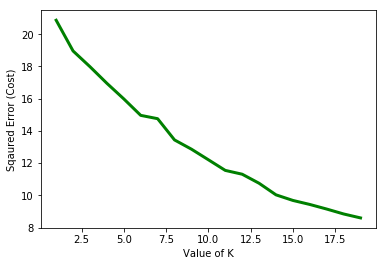

[20.865626072287547,
 18.958245080230743,
 17.981619207801536,
 16.95166678449003,
 15.98427418479322,
 14.963070025941677,
 14.756414074150614,
 13.43766813255377,
 12.864931036457374,
 12.208653684625965,
 11.547873740322498,
 11.311010826077784,
 10.749399489723086,
 10.03082027318369,
 9.683880582789298,
 9.433880582789298,
 9.148813894201298,
 8.843998999178378,
 8.598944776232631]

In [27]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

cost =[] 
for i in range(1, 20): 
    KM = KMeans(n_clusters = i, max_iter = 500, random_state=0) 
    KM.fit(toronto_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 20), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 
  
# the point of the elbow is the  
# most optimal value for choosing k 

cost


##### Unfortunately, there is no clear elbow point even at 20 clusters
##### Therefore, for the sake of simplicity, we will use 8 clusters since the is a big stepoff from 7 to 8

In [28]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 6, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 6, 1, 6, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 0, 1, 1, 1, 1, 1, 1, 6, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 6, 1, 6, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 6, 1, 1, 1, 6, 1, 1, 1, 1, 1, 6], dtype=int32)

In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.shape

(101, 12)

#### Here is where the difference in dataframe shape will have an effect. We we merge the toronto__merged and neighborhood_venues_sorted it will leave us with a neighborhood with a cluster value NaN. This neighborhood has no venues within 500 meters. As such we will drop that neighborhood from further analysis.

In [30]:
toronto_merged = df_ll

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head(20) 

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,4.0,Fast Food Restaurant,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Gym Pool
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,7.0,Bar,History Museum,Women's Store,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1.0,Intersection,Rental Car Location,Electronics Store,Spa,Breakfast Spot,Pizza Place,Mexican Restaurant,Medical Center,Women's Store,Discount Store
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1.0,Coffee Shop,Korean Restaurant,Insurance Office,Women's Store,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1.0,Hakka Restaurant,Bakery,Caribbean Restaurant,Athletics & Sports,Bank,Gas Station,Thai Restaurant,Fried Chicken Joint,Doner Restaurant,Dog Run
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1.0,Playground,Convenience Store,Women's Store,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,1.0,Department Store,Bus Station,Convenience Store,Coffee Shop,Hobby Shop,Chinese Restaurant,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,1.0,Bakery,Bus Line,Fast Food Restaurant,Park,Soccer Field,Metro Station,Bus Station,Intersection,Women's Store,Donut Shop
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,1.0,American Restaurant,Motel,Dim Sum Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Women's Store
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,1.0,College Stadium,Skating Rink,General Entertainment,Café,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop


In [31]:
toronto_merged.shape

(103, 16)

In [32]:
#row 16, Upper Rouge, has no venues, so we'll drop it
toronto_merged.dropna(inplace=True)
toronto_merged.shape

(102, 16)

In [33]:
#Change Cluster Labels back to int32 in order to map them below
toronto_merged = toronto_merged.astype({'Cluster Labels':'int32'})
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,4,Fast Food Restaurant,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Gym Pool
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,7,Bar,History Museum,Women's Store,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1,Intersection,Rental Car Location,Electronics Store,Spa,Breakfast Spot,Pizza Place,Mexican Restaurant,Medical Center,Women's Store,Discount Store
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1,Coffee Shop,Korean Restaurant,Insurance Office,Women's Store,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1,Hakka Restaurant,Bakery,Caribbean Restaurant,Athletics & Sports,Bank,Gas Station,Thai Restaurant,Fried Chicken Joint,Doner Restaurant,Dog Run


In [34]:
toronto_merged['Cluster Labels'].dtypes

dtype('int32')

In [35]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Looks like Cluster 1 is by far the largest and cluster 6 is a distant second. The rest appear to be small, unique neighborhoods. We'll drill down into those below.

In [38]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,North York,0,Baseball Field,Food Truck,Home Service,Women's Store,Diner,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
91,Etobicoke,0,Deli / Bodega,Baseball Field,Home Service,Women's Store,Diner,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
97,North York,0,Baseball Field,Women's Store,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Festival


#### Cluster 0 seem to be connected by baseball fields and Women's Stores

In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Scarborough,1,Intersection,Rental Car Location,Electronics Store,Spa,Breakfast Spot,Pizza Place,Mexican Restaurant,Medical Center,Women's Store,Discount Store
3,Scarborough,1,Coffee Shop,Korean Restaurant,Insurance Office,Women's Store,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,Scarborough,1,Hakka Restaurant,Bakery,Caribbean Restaurant,Athletics & Sports,Bank,Gas Station,Thai Restaurant,Fried Chicken Joint,Doner Restaurant,Dog Run
5,Scarborough,1,Playground,Convenience Store,Women's Store,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
6,Scarborough,1,Department Store,Bus Station,Convenience Store,Coffee Shop,Hobby Shop,Chinese Restaurant,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop
7,Scarborough,1,Bakery,Bus Line,Fast Food Restaurant,Park,Soccer Field,Metro Station,Bus Station,Intersection,Women's Store,Donut Shop
8,Scarborough,1,American Restaurant,Motel,Dim Sum Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Women's Store
9,Scarborough,1,College Stadium,Skating Rink,General Entertainment,Café,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
10,Scarborough,1,Indian Restaurant,Pet Store,Vietnamese Restaurant,Chinese Restaurant,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
11,Scarborough,1,Auto Garage,Sandwich Place,Breakfast Spot,Shopping Mall,Bakery,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore


In [46]:
#Further analysis of cluster 1 to determine unifying characteristics
cluster_1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + [2] + list(range(5, toronto_merged.shape[1]))]]
cluster_1.head()

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Scarborough,"Guildwood, Morningside, West Hill",1,Intersection,Rental Car Location,Electronics Store,Spa,Breakfast Spot,Pizza Place,Mexican Restaurant,Medical Center,Women's Store,Discount Store
3,Scarborough,Woburn,1,Coffee Shop,Korean Restaurant,Insurance Office,Women's Store,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,Scarborough,Cedarbrae,1,Hakka Restaurant,Bakery,Caribbean Restaurant,Athletics & Sports,Bank,Gas Station,Thai Restaurant,Fried Chicken Joint,Doner Restaurant,Dog Run
5,Scarborough,Scarborough Village,1,Playground,Convenience Store,Women's Store,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
6,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",1,Department Store,Bus Station,Convenience Store,Coffee Shop,Hobby Shop,Chinese Restaurant,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop


In [51]:
#create df of onehot values fro cluster 1
cluster_1_onehot = toronto_onehot[toronto_onehot['Neighborhood'].isin(cluster_1['Neighborhood'])]
cluster_1_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
#List most common venues
cluster_1_onehot.mean().sort_values(ascending = False).head(5)

Coffee Shop    0.083105
Café           0.045205
Restaurant     0.029224
Bakery         0.024658
Pizza Place    0.023288
dtype: float64

#### Cluster 1 has many coffee shops and cafes

In [40]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,North York,2,Piano Bar,Women's Store,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant


#### Cluster 2 seems to be unique in its prevelance of Piano Bars

In [41]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Central Toronto,3,Garden,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Women's Store,Dessert Shop


#### Cluster 3 has gardens

In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,4,Fast Food Restaurant,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Gym Pool


#### Cluster 4 has Fast Food Restaurants

In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
94,Etobicoke,5,Filipino Restaurant,Women's Store,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant


#### Cluster 5 has Filipino Restaurants

In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Scarborough,6,Park,Coffee Shop,Playground,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
23,North York,6,Park,Bank,Convenience Store,Bar,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
25,North York,6,Food & Drink Shop,Park,Women's Store,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
30,North York,6,Park,Airport,Women's Store,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
40,East York,6,Park,Metro Station,Convenience Store,Women's Store,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
44,Central Toronto,6,Park,Swim School,Bus Line,Drugstore,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Dim Sum Restaurant
50,Downtown Toronto,6,Park,Playground,Trail,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Event Space,Dumpling Restaurant,Department Store
74,York,6,Park,Women's Store,Market,Fast Food Restaurant,Gourmet Shop,Golf Course,Ethiopian Restaurant,Empanada Restaurant,Greek Restaurant,Electronics Store
79,North York,6,Park,Bakery,Construction & Landscaping,Women's Store,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
90,Etobicoke,6,River,Park,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant


#### Cluster 6 is Park heavy

In [45]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 7, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Scarborough,7,Bar,History Museum,Women's Store,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant


#### Cluster 7 has bars and history museums

### Conclusion
##### Cluster 0 = Baseball field Cluster
##### Cluster 1 = Coffee Shop Cluster
##### Cluster 2 = Piano Bar Cluster
##### Cluster 3 = Garden Cluster
##### Cluster 4 = Fast Food Cluster
##### Cluster 5 = Filipino Restaurant Cluster
##### Cluster 6 = Park Cluster
##### Cluster 7 = Bar Cluster